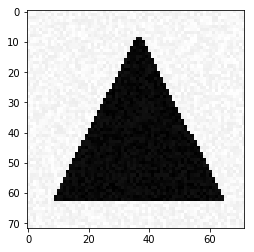

In [68]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]




# 3 simple classification

In [476]:
[X_train, Y_train] = generate_dataset_classification(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [477]:
X_train.shape

(300, 5184)

In [478]:
from keras import utils as np_utils
Y_train.shape
Y_train = np_utils.to_categorical(Y_train, num_classes=3)
print(Y_train.shape)

(300, 3)


In [479]:
import keras.utils
from keras.models import Sequential
from keras.layers import Dense, Activation

nb_neurons = 20
model_1 = Sequential([
    Dense(nb_neurons,input_shape=(5184,)),
    Activation('relu'),
    Dense(3),
    Activation('softmax'),
])


In [480]:
from keras.optimizers import SGD
sgd = SGD(lr=0.01,
    decay=1e-6, momentum=0.9,
    nesterov=True)
model_1.compile(loss='mean_squared_error',optimizer=sgd,metrics=['accuracy'])
model_1.fit(X_train, Y_train, epochs=200, batch_size=32)

Epoch 1/200
300/300 [==============================] - 3s 9ms/step - loss: 0.2448 - acc: 0.4433
Epoch 2/200
300/300 [==============================] - 0s 189us/step - loss: 0.1593 - acc: 0.6100
Epoch 3/200
300/300 [==============================] - 0s 176us/step - loss: 0.1299 - acc: 0.6933
Epoch 4/200
300/300 [==============================] - 0s 188us/step - loss: 0.1180 - acc: 0.7633
Epoch 5/200
300/300 [==============================] - 0s 180us/step - loss: 0.1123 - acc: 0.7567
Epoch 6/200
300/300 [==============================] - 0s 188us/step - loss: 0.1015 - acc: 0.8100
Epoch 7/200
300/300 [==============================] - 0s 196us/step - loss: 0.0859 - acc: 0.8700
Epoch 8/200
300/300 [==============================] - 0s 180us/step - loss: 0.0854 - acc: 0.8133
Epoch 9/200
300/300 [==============================] - 0s 183us/step - loss: 0.0684 - acc: 0.8933
Epoch 10/200
300/300 [==============================] - 0s 193us/step - loss: 0.0575 - acc: 0.8933
Epoch 11/200
300/300 

Epoch 83/200
300/300 [==============================] - 0s 189us/step - loss: 5.3334e-04 - acc: 1.0000
Epoch 84/200
300/300 [==============================] - 0s 186us/step - loss: 5.0940e-04 - acc: 1.0000
Epoch 85/200
300/300 [==============================] - 0s 176us/step - loss: 6.9426e-04 - acc: 1.0000
Epoch 86/200
300/300 [==============================] - 0s 176us/step - loss: 0.0013 - acc: 1.0000
Epoch 87/200
300/300 [==============================] - 0s 186us/step - loss: 5.9611e-04 - acc: 1.0000
Epoch 88/200
300/300 [==============================] - 0s 193us/step - loss: 4.8729e-04 - acc: 1.0000
Epoch 89/200
300/300 [==============================] - 0s 193us/step - loss: 4.4252e-04 - acc: 1.0000
Epoch 90/200
300/300 [==============================] - 0s 203us/step - loss: 4.5549e-04 - acc: 1.0000
Epoch 91/200
300/300 [==============================] - 0s 193us/step - loss: 4.2534e-04 - acc: 1.0000
Epoch 92/200
300/300 [==============================] - 0s 183us/step - loss:

Epoch 162/200
300/300 [==============================] - 0s 183us/step - loss: 1.8329e-04 - acc: 1.0000
Epoch 163/200
300/300 [==============================] - 0s 183us/step - loss: 1.7765e-04 - acc: 1.0000
Epoch 164/200
300/300 [==============================] - 0s 183us/step - loss: 1.8690e-04 - acc: 1.0000
Epoch 165/200
300/300 [==============================] - 0s 180us/step - loss: 1.7508e-04 - acc: 1.0000
Epoch 166/200
300/300 [==============================] - 0s 189us/step - loss: 1.7687e-04 - acc: 1.0000
Epoch 167/200
300/300 [==============================] - 0s 166us/step - loss: 1.7440e-04 - acc: 1.0000
Epoch 168/200
300/300 [==============================] - 0s 203us/step - loss: 1.7122e-04 - acc: 1.0000
Epoch 169/200
300/300 [==============================] - 0s 176us/step - loss: 1.7096e-04 - acc: 1.0000
Epoch 170/200
300/300 [==============================] - 0s 166us/step - loss: 1.6936e-04 - acc: 1.0000
Epoch 171/200
300/300 [==============================] - 0s 166u

In [481]:
from keras.optimizers import Adam
adm = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model_1.compile(loss='categorical_crossentropy',optimizer=adm,metrics=['accuracy'])
model_1.fit(X_train, Y_train, epochs=100, batch_size=32)

Epoch 1/100
300/300 [==============================] - 3s 9ms/step - loss: 0.3870 - acc: 0.8500
Epoch 2/100
300/300 [==============================] - 0s 199us/step - loss: 0.0687 - acc: 0.9867
Epoch 3/100
300/300 [==============================] - 0s 199us/step - loss: 0.0756 - acc: 0.9767
Epoch 4/100
300/300 [==============================] - 0s 203us/step - loss: 0.0267 - acc: 1.0000
Epoch 5/100
300/300 [==============================] - 0s 206us/step - loss: 0.0195 - acc: 1.0000
Epoch 6/100
300/300 [==============================] - 0s 189us/step - loss: 0.0153 - acc: 1.0000
Epoch 7/100
300/300 [==============================] - 0s 209us/step - loss: 0.0105 - acc: 1.0000
Epoch 8/100
300/300 [==============================] - 0s 203us/step - loss: 0.0098 - acc: 1.0000
Epoch 9/100
300/300 [==============================] - 0s 206us/step - loss: 0.0091 - acc: 1.0000
Epoch 10/100
300/300 [==============================] - 0s 217us/step - loss: 0.0084 - acc: 1.0000
Epoch 11/100
300/300 

300/300 [==============================] - 0s 196us/step - loss: 0.0012 - acc: 1.0000
Epoch 84/100
300/300 [==============================] - 0s 203us/step - loss: 0.0012 - acc: 1.0000
Epoch 85/100
300/300 [==============================] - 0s 219us/step - loss: 0.0012 - acc: 1.0000
Epoch 86/100
300/300 [==============================] - 0s 197us/step - loss: 0.0012 - acc: 1.0000
Epoch 87/100
300/300 [==============================] - 0s 195us/step - loss: 0.0011 - acc: 1.0000
Epoch 88/100
300/300 [==============================] - 0s 199us/step - loss: 0.0011 - acc: 1.0000
Epoch 89/100
300/300 [==============================] - 0s 196us/step - loss: 0.0011 - acc: 1.0000
Epoch 90/100
300/300 [==============================] - 0s 196us/step - loss: 0.0011 - acc: 1.0000
Epoch 91/100
300/300 [==============================] - 0s 196us/step - loss: 0.0011 - acc: 1.0000
Epoch 92/100
300/300 [==============================] - 0s 196us/step - loss: 0.0011 - acc: 1.0000
Epoch 93/100
300/300 [=

In [482]:
X_test = generate_a_disk()
X_test = X_test.reshape(1,X_test.shape[0])
print(model_1.predict(X_test))

[[0. 1. 0.]]


# 4 Visualization of the Solution

In [592]:
model_2.get_weights()

[array([[ 0.00151184,  0.00181847, -0.02540917],
        [ 0.01557132, -0.02974826, -0.03300652],
        [-0.02573783,  0.02789506, -0.01197678],
        ...,
        [ 0.01832882,  0.00625486,  0.02764025],
        [-0.0265344 ,  0.00970427, -0.00808141],
        [-0.03264755, -0.00999988,  0.01853164]], dtype=float32),
 array([0., 0., 0.], dtype=float32)]

# 5 A More Difficult Classification Problem

In [539]:
[X_train, Y_train] = generate_dataset_classification(500, 20, True)
[X_test, Y_test] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [540]:
from keras import utils as np_utils
Y_train.shape
Y_train = np_utils.to_categorical(Y_train, num_classes=3)
print(Y_train.shape)

(500, 3)


In [541]:
X_ = np.empty([500,72,72])
X_2 = np.empty([300,72,72])
for i in range(len(X_train)):
    X_[i] = X_train[i].reshape(72,72)
X_train = X_
for l in range(len(X_test)):
    X_2[l] = X_test[l].reshape(72,72)
X_test = X_2

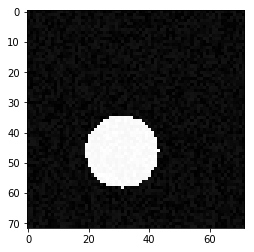

In [542]:
%matplotlib inline
plt.imshow(X_[18], cmap = cm.Greys)

In [543]:
X_train.shape

(500, 72, 72)

In [544]:
X_train = X_train.reshape(X_train.shape[0],72,72,1)
X_train = X_train.astype('float32')
X_train /= 255
X_train.shape

(500, 72, 72, 1)

In [546]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D

model = Sequential()
model.add(Conv2D(16, (5, 5),padding='same',input_shape=(72,72,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

from keras.layers import Flatten
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(3, activation='softmax'))

from keras.optimizers import Adam
adm = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',optimizer=adm,metrics=['accuracy'])
model.fit(X_train, Y_train,batch_size=32, epochs=15)

Epoch 1/15
500/500 [==============================] - 8s 17ms/step - loss: 1.0993 - acc: 0.3180
Epoch 2/15
500/500 [==============================] - 5s 9ms/step - loss: 1.0963 - acc: 0.4600
Epoch 3/15
500/500 [==============================] - 5s 9ms/step - loss: 1.0863 - acc: 0.4400
Epoch 4/15
500/500 [==============================] - 5s 9ms/step - loss: 1.0591 - acc: 0.4820
Epoch 5/15
500/500 [==============================] - 5s 9ms/step - loss: 1.0023 - acc: 0.5240
Epoch 6/15
500/500 [==============================] - 5s 9ms/step - loss: 0.9413 - acc: 0.5460
Epoch 7/15
500/500 [==============================] - 5s 10ms/step - loss: 0.8969 - acc: 0.5520
Epoch 8/15
500/500 [==============================] - 5s 9ms/step - loss: 0.8337 - acc: 0.5860
Epoch 9/15
500/500 [==============================] - 5s 9ms/step - loss: 0.8200 - acc: 0.6080
Epoch 10/15
500/500 [==============================] - 5s 9ms/step - loss: 0.7840 - acc: 0.5980
Epoch 11/15
500/500 [==========================

In [547]:
X_test = X_test.reshape(X_test.shape[0],72,72,1)
X_test = X_test.astype('float32')
X_test /= 255
X_test.shape

(300, 72, 72, 1)

In [548]:
scores = model.evaluate(X_test,Y_test)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

300/300 [==============================] - 2s 6ms/step
acc: 58.33%


# 6 A Regression Problem

In [549]:
[X_train, Y_train] = generate_dataset_regression(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


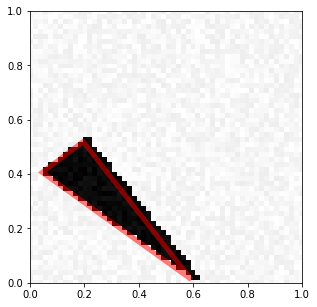

In [551]:
visualize_prediction(X_train[1], Y_train[1])

In [579]:
X_train[0].shape

(5184,)

In [580]:
Y_train[1].shape

(6,)

In [586]:
nb_neurons = 20
model = Sequential([
    Dense(nb_neurons,input_shape=(5184,)),
    Activation('relu'),
    Dense(6),
    Activation('relu'),
])


In [587]:
from keras.wrappers.scikit_learn import KerasRegressor
estimator = KerasRegressor(build_fn=model, epochs=100, batch_size=5, verbose=0)

In [589]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
seed = 7
np.random.seed(seed)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(estimator, X_train, Y_train, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

NameError: name 'results' is not defined

# 7 Imagine Denoising

In [ ]:
def generate_a_drawing_2(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    ax2 = plt.subplot(112)
    
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle_2(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing_2(figsize, U, V, noise)